In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import os

%matplotlib inline

In [ ]:
def is_unbounded_hull(p, neighbors):
    k, D = neighbors.shape
    if D == 1:
        vals = neighbors[:, 0]
        return not (np.any(vals < p[0]) and np.any(vals > p[0]))
    if k < D + 1:
        return True
    pts = np.vstack([neighbors, p])
    hull = ConvexHull(pts)
    return (k in hull.vertices)

In [ ]:
def central_cell_probability(D, N, k, num_experiments=500, seed=None):
    center = np.full((1, D), 0.5)
    unb_count = 0
    for _ in range(num_experiments):
        rng = np.random.RandomState(seed)
        pts = rng.rand(N-1, D)
        pts = np.vstack([pts, center])
        knn = NearestNeighbors(n_neighbors=k+1).fit(pts)
        _, idxs = knn.kneighbors(center)
        neigh = pts[idxs[0, 1:]]
        if is_unbounded_hull(center.ravel(), neigh):
            unb_count += 1
        seed += D + D*100
    return unb_count / num_experiments

### Запуск экспериментов

In [ ]:
NUM_EXPS = 2000
N = 500
DATA_DIR = "./data/all/"
os.makedirs(DATA_DIR, exist_ok=True)

results_all = []

for k in trange(1,21):
    results = []
    for D in range(1, 32):
        p_unb = central_cell_probability(D, N, k, num_experiments=NUM_EXPS, seed=42)
        results.append((D, N, k, p_unb))
        if p_unb == 1:
            break
    df = pd.DataFrame(results, columns=['D','N','k','P_unbounded'])
    csv_path = os.path.join(DATA_DIR, f'central_D1-32_k{k}.csv')
    df.to_csv(csv_path, index=False)
    results_all.append(df) 

import pandas as pd
df = pd.DataFrame(results, columns=['D','N','k','P_unbounded'])
df.to_csv(f'central_results_D1-64 k={k}.csv', index=False)

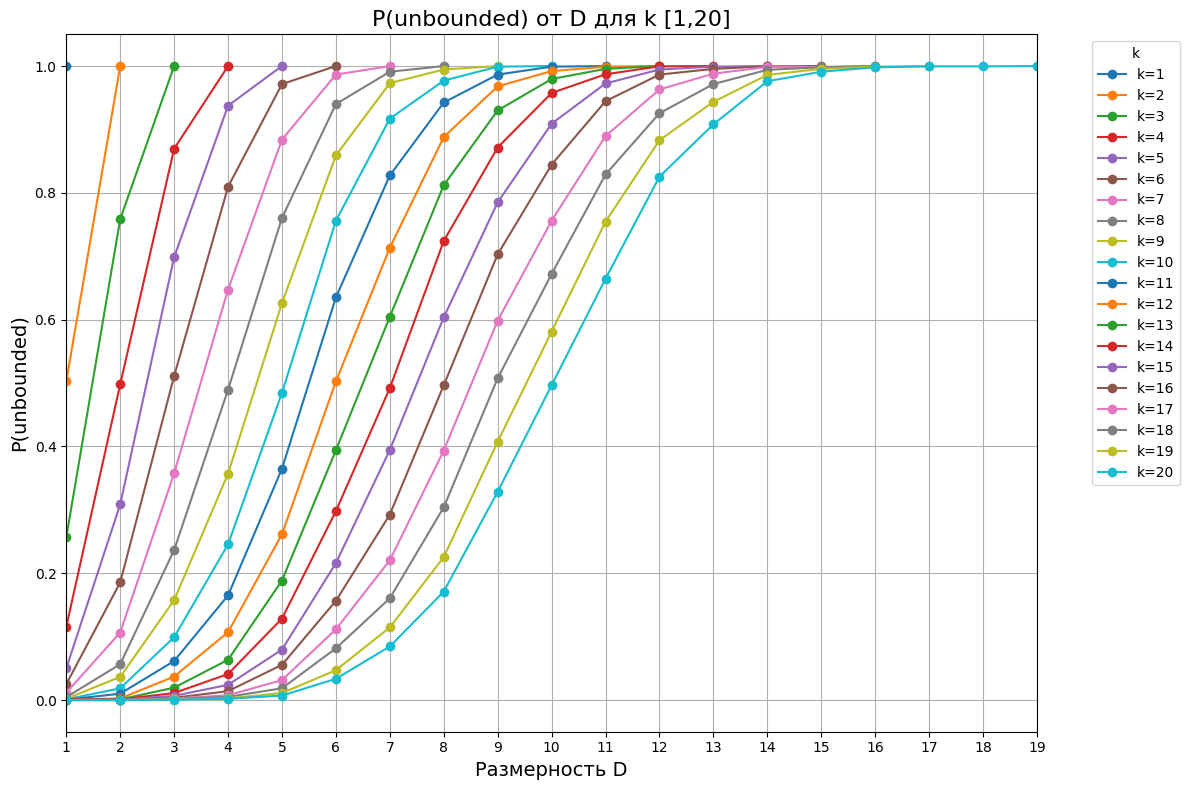

In [ ]:
DATA_DIR = "./data/all/"
plt.figure(figsize=(12, 8))
for k in range(1, 21):
    csv_path = os.path.join(DATA_DIR, f'central_D1-32_k{k}.csv')
    df = pd.read_csv(csv_path)
    plt.plot(df['D'], df['P_unbounded'], marker='o', linestyle='-', label=f'k={k}')

plt.xlabel('Размерность D', fontsize=14)
plt.ylabel('P(unbounded)', fontsize=14)
plt.title('P(unbounded) от D для k [1,20]', fontsize=16)
plt.grid(True)
plt.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 19)

plt.tight_layout()
plt.show()

### Объединение csv файлов в один

In [ ]:
import pandas as pd
import glob
import os

# Папка, в которой лежат CSV-файлы
DATA_DIR = './data/all/'
pattern = os.path.join(DATA_DIR, 'central_D1-32_k*.csv')
file_list = glob.glob(pattern)

dfs = []
for file_path in file_list:
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df.sort_values(by=['k', 'D']).reset_index(drop=True)

# Сохраняем в единый CSV
NEW_DIR = './data'
output_path = os.path.join(DATA_DIR, 'central_all_k1-20_D1-32.csv')
combined_df.to_csv(output_path, index=False)


### Сравнение с теоремой Венделя

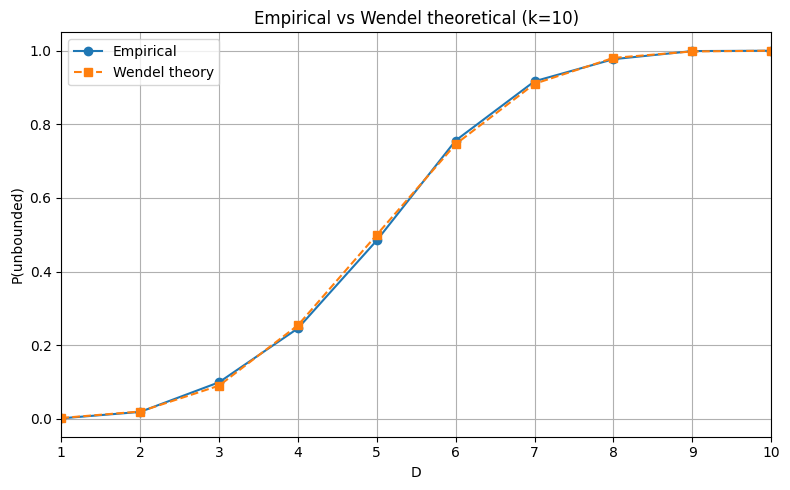

In [ ]:
import pandas as pd
import numpy as np
from math import comb
import matplotlib.pyplot as plt

df = pd.read_csv('./data/central_all_k1-20_D1-32.csv')

def p_wendel(k, D):
    if k <= D:
        return 1.0
    s = sum(comb(k-1, i) for i in range(D))
    return s / (2**(k-1))

df['P_theoretical'] = df.apply(lambda row: p_wendel(int(row['k']), int(row['D'])), axis=1)
df['error'] = df['P_unbounded'] - df['P_theoretical']

sample = df[df['k'].isin([5, 10, 20]) & (df['D']<=10)]

sub = df[df['k'] == 10]
plt.figure(figsize=(8, 5))
plt.plot(sub['D'], sub['P_unbounded'], 'o-', label='Empirical')
plt.plot(sub['D'], sub['P_theoretical'], 's--', label='Wendel theory')
plt.xlabel('D')
plt.ylabel('P(unbounded)')
plt.title('Empirical vs Wendel theoretical (k=10)')
plt.legend()
plt.grid(True)
from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 10)

plt.tight_layout()
plt.show()


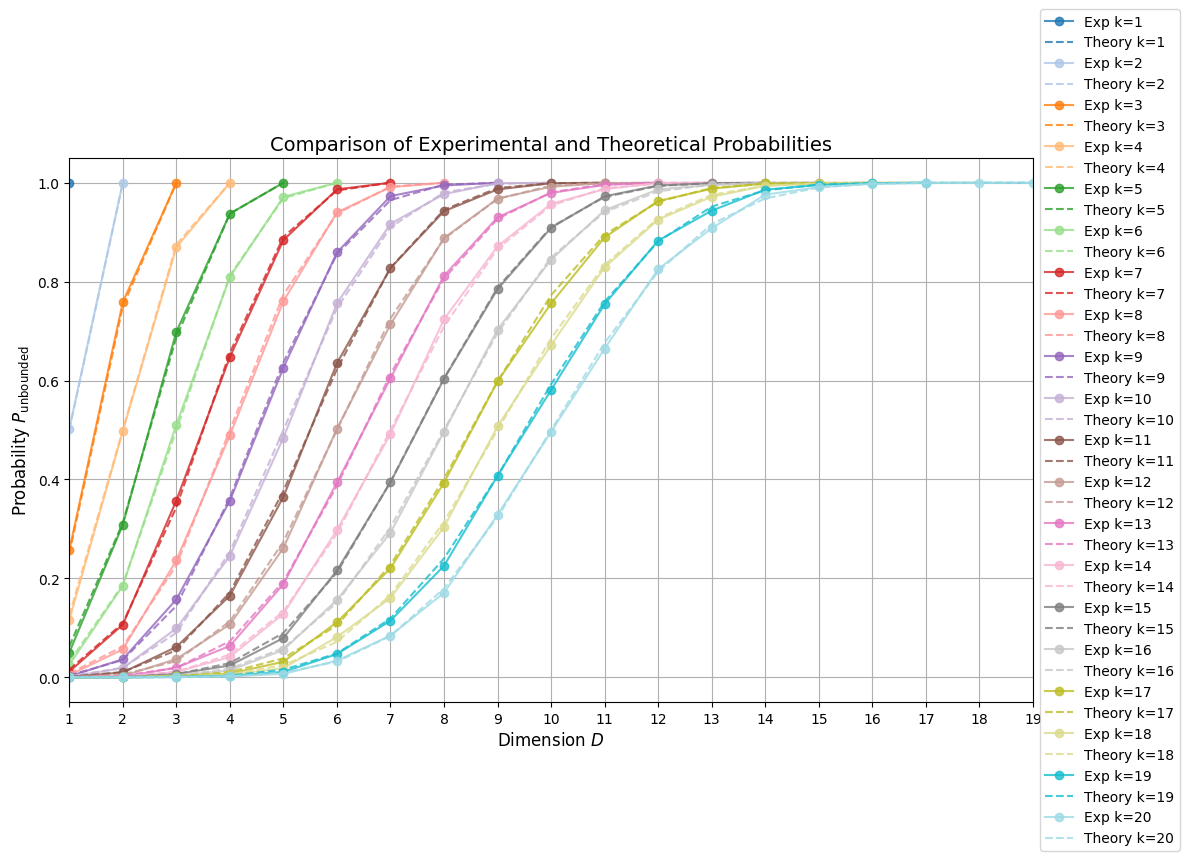

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# Теоретическая вероятность незамкнутости
def theoretical_probability(D, k):
    if k <= D:
        return 1.0
    s = sum(comb(k-1, i) for i in range(D))
    return s / (2**(k-1))

df = pd.read_csv('./data/central_all_k1-20_D1-32.csv')

k_values = sorted(df['k'].unique())

plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(k_values)))

for idx, k in enumerate(k_values):
    df_k = df[df['k'] == k]
    D_exp = df_k['D'].values
    P_exp = df_k['P_unbounded'].values

    # Генерация теоретических значений для D от 1 до k
    D_theory = np.arange(1, k + 1)
    P_theory = [theoretical_probability(d, k) for d in D_theory]

    plt.plot(D_exp, P_exp, 'o-', color=colors[idx], label=f'Exp k={k}', alpha=0.8)
    plt.plot(D_theory, P_theory, '--', color=colors[idx], label=f'Theory k={k}', alpha=0.8)

plt.xlabel('Dimension $D$', fontsize=12)
plt.ylabel('Probability $P_{\\text{unbounded}}$', fontsize=12)
plt.title('Comparison of Experimental and Theoretical Probabilities', fontsize=14)
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 19)

plt.tight_layout()

plt.show()

Статистика абсолютной ошибки по D:
         mean       max
D                     
1   0.002439  0.012500
2   0.001902  0.008500
3   0.004794  0.013750
4   0.004646  0.010500
5   0.007354  0.015500
6   0.005032  0.011953
7   0.005349  0.012086
8   0.005892  0.014841
9   0.002894  0.007500
10  0.005301  0.016751
11  0.003567  0.011697
12  0.001973  0.005142
13  0.003314  0.008466
14  0.001709  0.007784
15  0.000687  0.001241
16  0.000177  0.000344
17  0.000104  0.000136
18  0.000462  0.000462
19  0.000002  0.000002


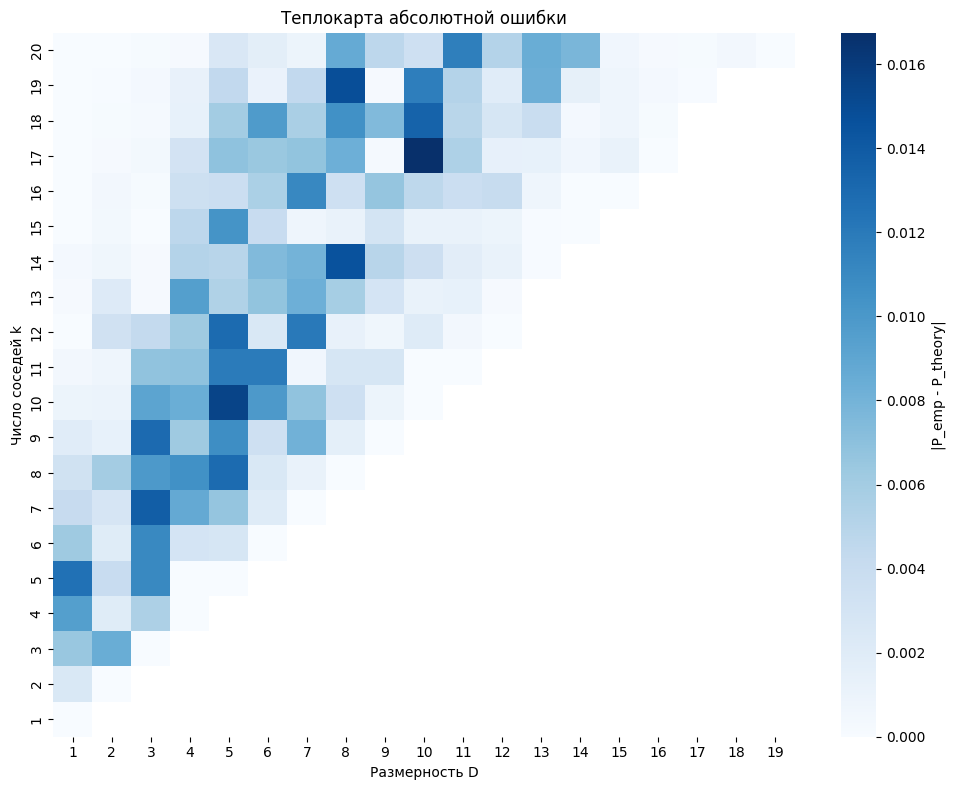

In [ ]:
import pandas as pd
import numpy as np
from math import comb
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Загрузка данных
df = pd.read_csv('./data/central_all_k1-20_D1-32.csv')

# 2) Добавляем теоретическую колонку и ошибку
def p_out_wendel(k, D):
    if k <= D:
        return 1.0
    return sum(comb(k-1, i) for i in range(D)) / 2**(k-1)

def p_closed_wendel(k, D):
    return 1 - p_out_wendel(k, D)

# Вычисляем P_theoretical и error
df['P_theoretical'] = df.apply(lambda row: p_out_wendel(int(row['k']), int(row['D'])), axis=1)
df['error'] = df['P_unbounded'] - df['P_theoretical']

# 3) Абсолютная ошибка и статистики
df['abs_error'] = df['error'].abs()
stats = df.groupby('D')['abs_error'].agg(['mean','max'])
print("Статистика абсолютной ошибки по D:\n", stats)
output_path2 = os.path.join('./data', 'temp.csv')
stats_write = stats.round(6)
stats_write.to_csv(output_path2, index=False)

import seaborn as sns
import matplotlib.pyplot as plt

pivot = df.pivot(index='k', columns='D', values='abs_error')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    pivot,
    cmap='Blues',
    cbar_kws={'label': '|P_emp - P_theory|'},
    xticklabels=True,
    yticklabels=True
)

# Инвертируем ось Y, чтобы k=1 был внизу, а k=20 — вверху
ax.invert_yaxis()

plt.xlabel('Размерность D')
plt.ylabel('Число соседей k')
plt.title('Теплокарта абсолютной ошибки')
plt.tight_layout()
plt.show()


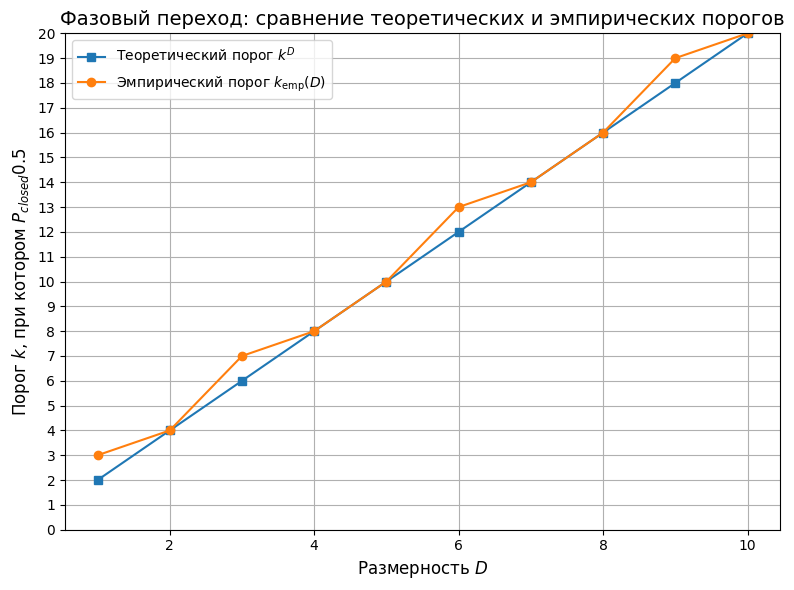

In [ ]:
import pandas as pd
import numpy as np
from math import comb
import matplotlib.pyplot as plt

# 1) Загрузка данных
df = pd.read_csv('./data/central_all_k1-20_D1-32.csv')

# 2) Теоретическая функция Венделя P_out = P(ячейка незамкнута)
def p_out_wendel(k, D):
    if k <= D:
        return 1.0
    return sum(comb(k-1, i) for i in range(D)) / 2**(k-1)

# Теоретическая вероятность замкнутости
def p_closed_wendel(k, D):
    return 1 - p_out_wendel(k, D)

# 3) Находим для каждой D теоретический k*: минимальное k с P_closed >= 0.5
theory_thresh = {}
max_k = df['k'].max()
for D in sorted(df['D'].unique()):
    for k in range(1, max_k+1):
        if p_closed_wendel(k, D) >= 0.5:
            theory_thresh[D] = k
            break

# 4) Находим для каждой D эмпирический порог: минимальное k с P_unbounded <= 0.5
#    (или P_closed_emp >= 0.5)
emp_thresh = {}
for D in sorted(df['D'].unique()):
    sub = df[df['D'] == D]
    # P_closed_emp = 1 - P_unbounded
    sub = sub.assign(P_closed_emp=1 - sub['P_unbounded'])
    # фильтруем k по P_closed_emp >= 0.5
    valid = sub[sub['P_closed_emp'] >= 0.5]
    if not valid.empty:
        emp_thresh[D] = int(valid.iloc[0]['k'])
    else:
        emp_thresh[D] = np.nan

# 5) Переводим в списки для графика
Ds = list(theory_thresh.keys())
k_theory = [theory_thresh[D] for D in Ds]
k_emp = [emp_thresh[D] for D in Ds]

# 6) Рисуем
# 6) Рисуем
plt.figure(figsize=(8,6))
plt.plot(Ds, k_theory, 's-', label=r'Теоретический порог $k^D$')
plt.plot(Ds, k_emp, 'o-', label=r'Эмпирический порог $k_{\mathrm{emp}}(D)$')
plt.xlabel(r'Размерность $D$', fontsize=12)
# Вот здесь оборачиваем всю метку в raw-строку
plt.ylabel(r'Порог $k$, при котором $P_{closed} 0.5$', fontsize=12)

plt.title('Фазовый переход: сравнение теоретических и эмпирических порогов', fontsize=14)
plt.grid(True)
plt.legend(loc='best')
from matplotlib.ticker import MultipleLocator
ay = plt.gca()
ay.yaxis.set_major_locator(MultipleLocator(1))
plt.ylim(0, 20)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd

rows = []
for D in sorted(theory_thresh):
    rows.append({
        'D': D,
        'k_theory': theory_thresh[D],
        'k_emp': emp_thresh[D],
        'delta_k': emp_thresh[D] - theory_thresh[D]
    })
df_thresh = pd.DataFrame(rows)
print(df_thresh)
output_path2 = os.path.join('./data', 'phase.csv')
df_thresh.to_csv(output_path2, index=False)

    D  k_theory  k_emp  delta_k
0   1         2      3        1
1   2         4      4        0
2   3         6      7        1
3   4         8      8        0
4   5        10     10        0
5   6        12     13        1
6   7        14     14        0
7   8        16     16        0
8   9        18     19        1
9  10        20     20        0


In [ ]:
widths = []
for D in sorted(df['D'].unique()):
    sub = df[df['D']==D].assign(P_closed_emp=1-df[df['D']==D]['P_unbounded'])
    def find_k(p):
        valid = sub[sub['P_closed_emp']>=p]
        return int(valid.iloc[0]['k']) if not valid.empty else None

    k10 = find_k(0.1)
    k90 = find_k(0.9)
    widths.append({'D':D, 'k10%':k10, 'k90%':k90, 'width': (k90-k10) if k10 and k90 else None})

df_width = pd.DataFrame(widths)
print(df_width)
output_path2 = os.path.join('./data', 'width.csv')
df_width.to_csv(output_path2, index=False)


     D  k10%  k90%  width
0    1   2.0   5.0    3.0
1    2   3.0   8.0    5.0
2    3   4.0  10.0    6.0
3    4   6.0  13.0    7.0
4    5   7.0  15.0    8.0
5    6   9.0  18.0    9.0
6    7  11.0  20.0    9.0
7    8  12.0   NaN    NaN
8    9  14.0   NaN    NaN
9   10  16.0   NaN    NaN
10  11  17.0   NaN    NaN
11  12  19.0   NaN    NaN
12  13   NaN   NaN    NaN
13  14   NaN   NaN    NaN
14  15   NaN   NaN    NaN
15  16   NaN   NaN    NaN
16  17   NaN   NaN    NaN
17  18   NaN   NaN    NaN
18  19   NaN   NaN    NaN


<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:4: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ivan2\AppData\Local\Temp\ipykernel_27652\3210320504.py:4: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Ширина фазового перехода $k_{90\%} - k_{10\%}$')


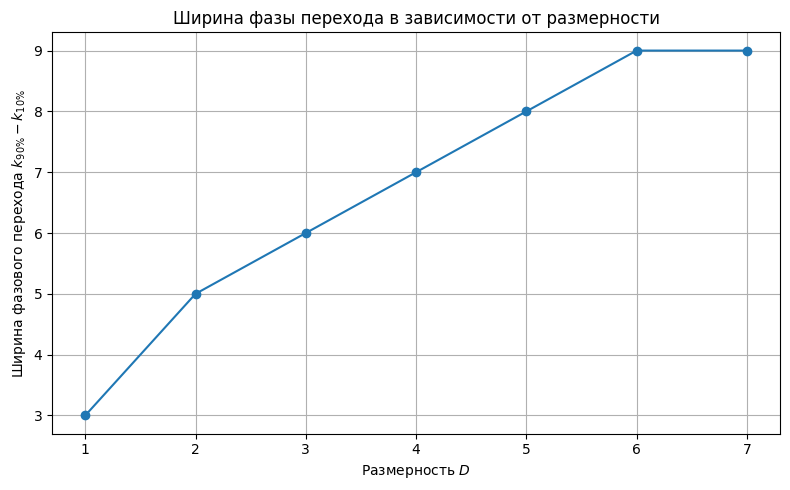

In [22]:
plt.figure(figsize=(8,5))
plt.plot(df_width['D'], df_width['width'], 'o-')
plt.xlabel('Размерность $D$')
plt.ylabel('Ширина фазового перехода $k_{90\%} - k_{10\%}$')
plt.title('Ширина фазы перехода в зависимости от размерности')
plt.grid(True)
plt.tight_layout()
plt.show()